---

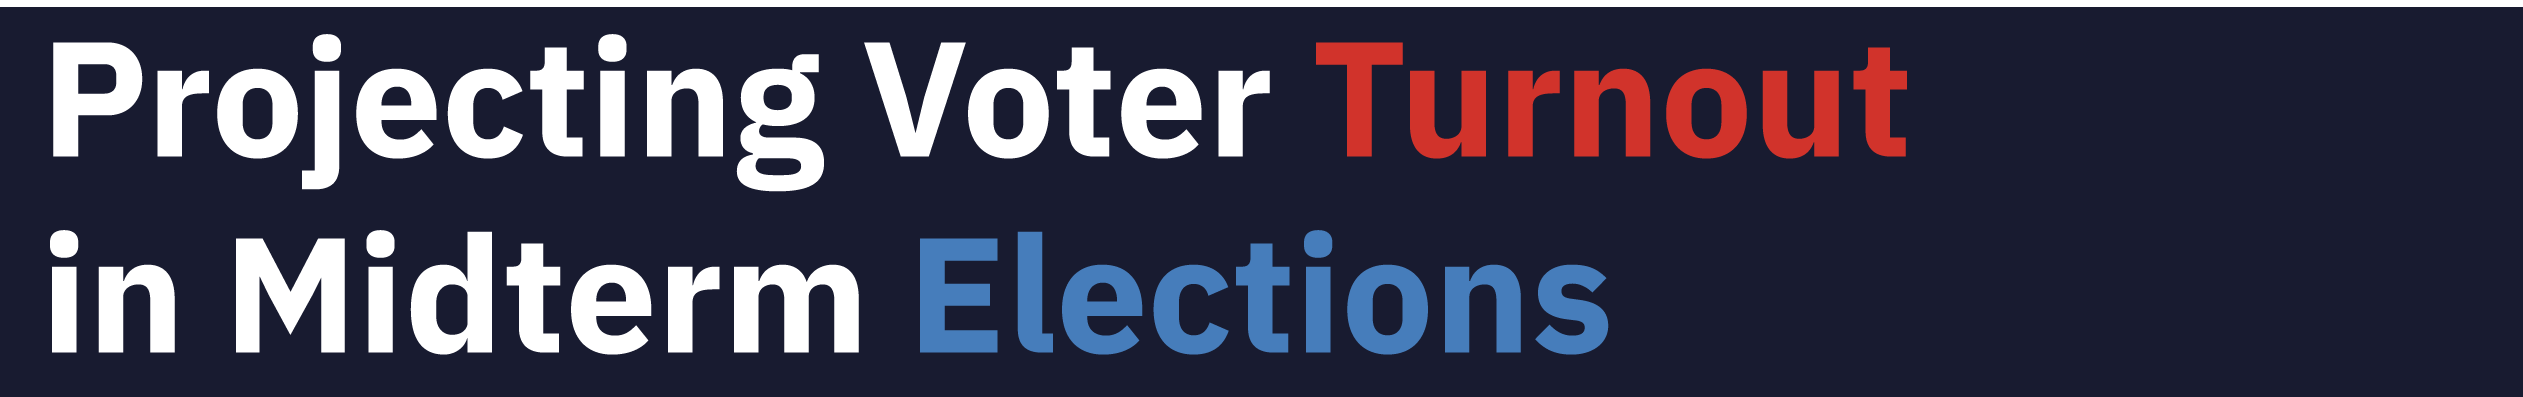

---

***Project By:***

>***David White***
>
>*GitHub  Profile: [@davidwhitemsm](https://github.com/davidwhitemsm)*
>
>*Email: <david@msmdesign.nyc>*
>
>*Date: June 2022*
>
>
>*Accompanying Presentation Slides: <https://tinyurl.com/david-white-ga-project-slides>*

---

***Project Description:***

*The goal of this project is to use publicly-available election returns and US Census Bureau data to build a model that predicts turnout in midterm elections in the state of Georgia. The machine learning model's predictiveness  will then be measured against the traditional method of projecting voter turnout in an election.*

---

---

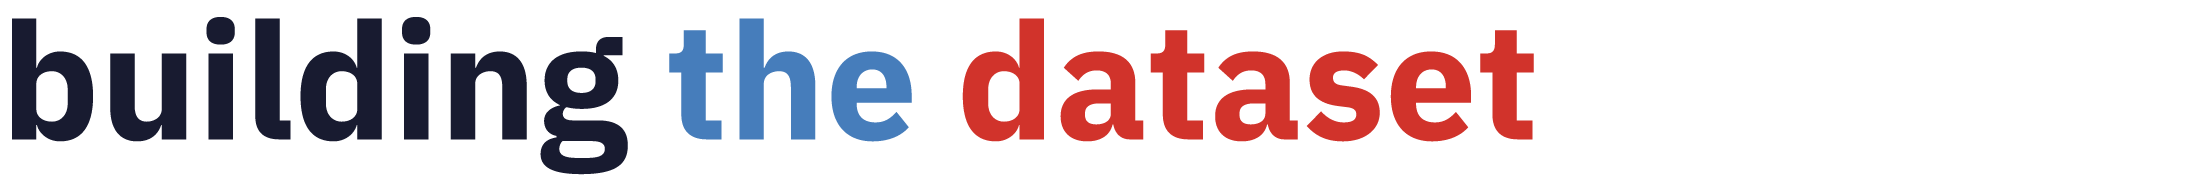

---

### 1.1 Locate and download election results from the Georgia Secretary of State's website

---

-  **[2018 Georgia Election Results by County and Precinct](https://results.enr.clarityelections.com/GA/91639/Web02-state.221451/#/access-to-races)**

-  **[2014 Georgia Election Results by County and Precinct](https://results.enr.clarityelections.com/GA/54042/149045/en/select-county.html)**

-  **[2010 Georgia Election Results by County and Precinct](https://git.generalassemb.ly/davidwhite-ga/unit-4_project/blob/master/data/november_2010_general_election_voters_by_age_race_gender_county_precinct.pdf)**

-  **[2006 Georgia Election Results by County and Precinct](https://git.generalassemb.ly/davidwhite-ga/unit-4_project/blob/master/data/november_2006_general_election_voters_by_age_race_gender_county_precinct.pdf)**

---

### 1.2 Locate and download Federal Information Processing Standards (FIPS) codes

---

These codes will be used later to join county-level data to census tract data.

-  **[FIPS Codes by US State and Territory](https://www.nrcs.usda.gov/wps/portal/nrcs/detail/ga/home/?cid=nrcs143_013696)**

-  **[FIPS Codes by County](https://www.nrcs.usda.gov/wps/portal/nrcs/detail/ga/home/?cid=nrcs143_013697)**

---

### 1.3 Use Google BigQuery to organize and combine the data 

---

***Diagram of the ```political-data-354221``` project in Google BigQuery***

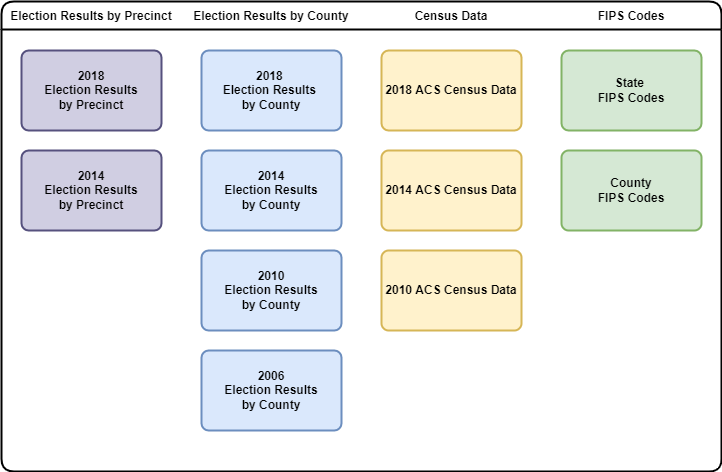

---

### 1.4 Aggregate precinct-level election returns using Google BigQuery

---

```sql
--create a summary table of county-level 2018 election results
CREATE OR REPLACE TABLE 
`political-data-354221.election_returns.georgia_midterm_general_election_results_by_county_fips_code_2018`  AS

SELECT
precincts.state,	
precincts.county,
--add FIPS code for each county to allow census data to be joined later
county_fips_code,
election_year,	
election_name,	
SUM(registered_voters) AS registered_voters,
SUM(ballots_cast) AS ballots_cast


FROM
`political-data-354221.election_returns.georgia_midterm_general_election_results_by_precinct_2018` precincts


LEFT JOIN 
`political-data-354221.census_data.FIPS_county_codes` fips

ON
precincts.county = fips.county AND precincts.state = fips.us_state_or_territory

GROUP BY state, county, county_fips_code, election_year, election_name
;
```

---

>***Repeat this process to aggregate the 2014 election returns by precinct.***

---

### 1.5 Pull census data from the BigQuery public datasets

---

```sql
----pull 2018 acs census data from BigQuery public data for the state of Georgia by county and save the results in a new table----
CREATE OR REPLACE TABLE `political-data-354221.census_data.georgia_census_data_by_county_2018` AS

SELECT
--the first 5 characters of the geo_id indicate the county's FIPS code
LEFT (geo_id, 5) AS county_fips,

--specify the census year to allow for joining other tables by year later
'2018' AS census_year,

--select race data
ROUND (SUM(white_pop) / SUM(total_pop),3) AS white_pct,
ROUND (SUM(black_pop) / SUM(total_pop),3) AS black_pct,
ROUND (SUM(hispanic_pop) / SUM(total_pop),3) AS hispanic_pct,
ROUND (SUM(asian_pop) / SUM(total_pop),3) AS asian_pct,
ROUND (SUM(amerindian_pop) / SUM(total_pop),3) AS amerindian_pct,
ROUND (SUM(other_race_pop) / SUM(total_pop),3) AS other_race_pct,


--select gender data
ROUND (SUM(male_pop) / SUM(total_pop),3) AS male_pct,
ROUND (SUM(female_pop) / SUM(total_pop),3) AS female_pct,


--select age data
--population ages 0 to 17
ROUND((SUM(male_under_5) + SUM(female_under_5) +
SUM(male_5_to_9) + SUM(female_5_to_9) +
SUM(male_10_to_14) + SUM(female_10_to_14) +
SUM(male_15_to_17) + SUM(female_15_to_17) ) / SUM(total_pop),3) AS under_age_18_pct ,

--population ages 18 to 24
ROUND((SUM(male_18_to_19) + SUM(female_18_to_19) + 
SUM(male_20) + SUM(female_20) +
SUM(male_21) + SUM(female_21) +
SUM(male_22_to_24) + SUM(female_22_to_24) ) / SUM(total_pop),3) AS ages_18_to_24_pct ,

--population ages 25 to 39
ROUND((SUM(male_25_to_29) + SUM(female_25_to_29) + 
SUM(male_30_to_34) + SUM(female_30_to_34) +
SUM(male_35_to_39) + SUM(female_35_to_39) ) / SUM(total_pop),3) AS ages_25_to_39_pct ,

--population ages 40 to 64
ROUND((SUM(male_40_to_44) + SUM(female_40_to_44) + 
SUM(male_45_to_49) + SUM(female_45_to_49) +
SUM(male_50_to_54) + SUM(female_50_to_54) +
SUM(male_55_to_59) + SUM(female_55_to_59) +
SUM(male_60_to_61) + SUM(female_60_to_61) +
SUM(male_62_to_64) + SUM(female_62_to_64) ) / SUM(total_pop),3) AS ages_40_to_64_pct ,

--population ages 65 and over
ROUND((SUM(male_65_to_66) + SUM(female_65_to_66) + 
SUM(male_67_to_69) + SUM(female_67_to_69) +
SUM(male_70_to_74) + SUM(female_70_to_74) +
SUM(male_75_to_79) + SUM(female_75_to_79) +
SUM(male_80_to_84) + SUM(female_80_to_84) +
SUM(male_85_and_over) + SUM(female_85_and_over) ) / SUM(total_pop),3) AS ages_65_and_over_pct ,


--select education data
--percentage of adults 25 or older who's highest level of education is a high school diploma
ROUND (SUM(high_school_diploma) / 
(SUM(male_25_to_29) + SUM(female_25_to_29) + 
SUM(male_30_to_34) + SUM(female_30_to_34) +
SUM(male_35_to_39) + SUM(female_35_to_39) +
SUM(male_40_to_44) + SUM(female_40_to_44) +
SUM(male_45_to_49) + SUM(female_45_to_49) +
SUM(male_50_to_54) + SUM(female_50_to_54) +
SUM(male_55_to_59) + SUM(female_55_to_59) +
SUM(male_60_to_61) + SUM(female_60_to_61) +
SUM(male_62_to_64) + SUM(female_62_to_64) +
SUM(male_65_to_66) + SUM(female_65_to_66) +
SUM(male_67_to_69) + SUM(female_67_to_69) +
SUM(male_70_to_74) + SUM(female_70_to_74) +
SUM(male_75_to_79) + SUM(female_75_to_79) +
SUM(male_80_to_84) + SUM(female_80_to_84) +
SUM(male_85_and_over) + SUM(female_85_and_over)),3) AS highest_edudation_level_high_school_diploma_pct ,

--percentage of adults 25 or older who's highest level of education is a bachelor's degree
ROUND (SUM(bachelors_degree) / 
(SUM(male_25_to_29) + SUM(female_25_to_29) + 
SUM(male_30_to_34) + SUM(female_30_to_34) +
SUM(male_35_to_39) + SUM(female_35_to_39) +
SUM(male_40_to_44) + SUM(female_40_to_44) +
SUM(male_45_to_49) + SUM(female_45_to_49) +
SUM(male_50_to_54) + SUM(female_50_to_54) +
SUM(male_55_to_59) + SUM(female_55_to_59) +
SUM(male_60_to_61) + SUM(female_60_to_61) +
SUM(male_62_to_64) + SUM(female_62_to_64) +
SUM(male_65_to_66) + SUM(female_65_to_66) +
SUM(male_67_to_69) + SUM(female_67_to_69) +
SUM(male_70_to_74) + SUM(female_70_to_74) +
SUM(male_75_to_79) + SUM(female_75_to_79) +
SUM(male_80_to_84) + SUM(female_80_to_84) +
SUM(male_85_and_over) + SUM(female_85_and_over)),3) AS highest_edudation_level_bachelors_degree_pct ,

--percentage of adults 25 or older who's highest level of education is a master's degree
ROUND (SUM(masters_degree) / 
(SUM(male_25_to_29) + SUM(female_25_to_29) + 
SUM(male_30_to_34) + SUM(female_30_to_34) +
SUM(male_35_to_39) + SUM(female_35_to_39) +
SUM(male_40_to_44) + SUM(female_40_to_44) +
SUM(male_45_to_49) + SUM(female_45_to_49) +
SUM(male_50_to_54) + SUM(female_50_to_54) +
SUM(male_55_to_59) + SUM(female_55_to_59) +
SUM(male_60_to_61) + SUM(female_60_to_61) +
SUM(male_62_to_64) + SUM(female_62_to_64) +
SUM(male_65_to_66) + SUM(female_65_to_66) +
SUM(male_67_to_69) + SUM(female_67_to_69) +
SUM(male_70_to_74) + SUM(female_70_to_74) +
SUM(male_75_to_79) + SUM(female_75_to_79) +
SUM(male_80_to_84) + SUM(female_80_to_84) +
SUM(male_85_and_over) + SUM(female_85_and_over)),3) AS highest_edudation_level_masters_degree_pct ,


--select household income data
--household income less than $20,000
ROUND((SUM(income_less_10000) + 
SUM(income_10000_14999) +
SUM(income_15000_19999)) / SUM(households),3) AS household_income_less_than_10k_pct ,

--household income between $20,000 and $39,999
ROUND((SUM(income_20000_24999) + 
SUM(income_25000_29999) +
SUM(income_30000_34999) +
SUM(income_35000_39999)) / SUM(households),3) AS household_income_20_to_40k_pct ,

--household income between $40,000 and $59,999
ROUND((SUM(income_40000_44999) + 
SUM(income_45000_49999) +
SUM(income_50000_59999)) / SUM(households),3) AS household_income_40_to_60k_pct ,

--household income between $60,000 and $99,999
ROUND((SUM(income_60000_74999) + 
SUM(income_75000_99999)) / SUM(households),3) AS income_60_to_100k_pct ,

--household income between $100,000 and $199,999
ROUND((SUM(income_100000_124999) + 
SUM(income_125000_149999) +
SUM(income_150000_199999)) / SUM(households),3) AS household_income_100_to_200k_pct ,

--household income between $200,000 or more
ROUND(SUM(income_200000_or_more) / SUM(households),3) AS household_income_200k_or_more_pct ,

--select overall poverty rate
ROUND(SUM(poverty) / SUM(total_pop),3) AS poverty_pct ,


--select household attributes data
ROUND(SUM(families_with_young_children) / SUM(family_households),3) AS families_with_young_children_pct ,

ROUND(SUM(married_households) / SUM(households),3) AS married_households_pct ,

--select transpotation data
ROUND(SUM(commuters_by_public_transportation) / SUM(employed_pop),3) AS commuters_by_public_transportation_pct ,

ROUND(SUM(no_cars) / SUM(households),3) AS households_without_a_car_pct ,



FROM `bigquery-public-data.census_bureau_acs.censustract_2018_5yr` census_18



--the first two characters of the geo_1d indicate the state's FIPS code
--limit the results to census tracts within the state of Georgia
WHERE LEFT(geo_id, 2) = '13'



--group the results by county
GROUP BY county_fips
 ;
```

>***Repeat this process to pull 2014 and 2010 American Community Survey data.***

---

### 1.6 Combine all election returns and census data into a single BigQuery table

---

``` sql
--combine all 2018, 2014, 2010 & 2006 election returns and 2018, 2014 & 2010 census data into a single datasource
CREATE OR REPLACE TABLE
`political-data-354221.datasources.georgia_midterm_elections_2006_through_2018` AS

SELECT
--select columns from 2018 election results
election2018.state AS state,
election2018.county AS county,
election2018.county_fips_code AS fips_code,
election2018.registered_voters AS election2018_registered_voters,
election2018.ballots_cast AS election2018_ballots_cast,

--select columns from 2014 election results
election2014.registered_voters AS election2014_registered_voters,
election2014.ballots_cast AS election2014_ballots_cast,

--select columns from 2010 election results
election2010.registered_voters AS election2010_registered_voters,
election2010.ballots_cast AS election2010_ballots_cast,

--select columns from 2006 election results
election2006.registered_voters AS election2006_registered_voters,
election2006.ballots_cast AS election2006_ballots_cast,

--select columns from 2018 American Community Survey
census2018.white_pct AS census2018_white_pct,
census2018.black_pct AS census2018_black_pct,
census2018.hispanic_pct AS census2018_hispanic_pct,
census2018.asian_pct AS census2018_asian_pct,
census2018.amerindian_pct AS census2018_amerindian_pct,
census2018.other_race_pct AS census2018_other_race_pct,
census2018.male_pct AS census2018_male_pct,
census2018.female_pct AS census2018_female_pct,
census2018.under_age_18_pct AS census2018_under_age_18_pct,
census2018.ages_18_to_24_pct AS census2018_ages_18_to_24_pct,
census2018.ages_25_to_39_pct AS census2018_ages_25_to_39_pct,
census2018.ages_40_to_64_pct AS census2018_ages_40_to_64_pct,
census2018.ages_65_and_over_pct AS census2018_ages_65_and_over_pct,
census2018.highest_edudation_level_high_school_diploma_pct AS census2018_highest_edudation_level_high_school_diploma_pct,
census2018.highest_edudation_level_bachelors_degree_pct AS census2018_highest_edudation_level_bachelors_degree_pct,
census2018.highest_edudation_level_masters_degree_pct AS census2018_highest_edudation_level_masters_degree_pct,
census2018.household_income_less_than_10k_pct AS census2018_household_income_less_than_10k_pct,
census2018.household_income_20_to_40k_pct AS census2018_household_income_20_to_40k_pct,
census2018.household_income_40_to_60k_pct AS census2018_household_income_40_to_60k_pct,
census2018.income_60_to_100k_pct AS census2018_income_60_to_100k_pct,
census2018.household_income_100_to_200k_pct AS census2018_household_income_100_to_200k_pct,
census2018.household_income_200k_or_more_pct AS census2018_household_income_200k_or_more_pct,
census2018.poverty_pct AS census2018_poverty_pct,
census2018.families_with_young_children_pct AS census2018_families_with_young_children_pct,
census2018.married_households_pct AS census2018_married_households_pct,
census2018.commuters_by_public_transportation_pct AS census2018_commuters_by_public_transportation_pct,
census2018.households_without_a_car_pct AS census2018_households_without_a_car_pct,

--select columns from 2014 American Community Survey
census2014.white_pct AS census2014_white_pct,
census2014.black_pct AS census2014_black_pct,
census2014.hispanic_pct AS census2014_hispanic_pct,
census2014.asian_pct AS census2014_asian_pct,
census2014.amerindian_pct AS census2014_amerindian_pct,
census2014.other_race_pct AS census2014_other_race_pct,
census2014.male_pct AS census2014_male_pct,
census2014.female_pct AS census2014_female_pct,
census2014.under_age_18_pct AS census2014_under_age_18_pct,
census2014.ages_18_to_24_pct AS census2014_ages_18_to_24_pct,
census2014.ages_25_to_39_pct AS census2014_ages_25_to_39_pct,
census2014.ages_40_to_64_pct AS census2014_ages_40_to_64_pct,
census2014.ages_65_and_over_pct AS census2014_ages_65_and_over_pct,
census2014.highest_edudation_level_high_school_diploma_pct AS census2014_highest_edudation_level_high_school_diploma_pct,
census2014.highest_edudation_level_bachelors_degree_pct AS census2014_highest_edudation_level_bachelors_degree_pct,
census2014.highest_edudation_level_masters_degree_pct AS census2014_highest_edudation_level_masters_degree_pct,
census2014.household_income_less_than_10k_pct AS census2014_household_income_less_than_10k_pct,
census2014.household_income_20_to_40k_pct AS census2014_household_income_20_to_40k_pct,
census2014.household_income_40_to_60k_pct AS census2014_household_income_40_to_60k_pct,
census2014.income_60_to_100k_pct AS census2014_income_60_to_100k_pct,
census2014.household_income_100_to_200k_pct AS census2014_household_income_100_to_200k_pct,
census2014.household_income_200k_or_more_pct AS census2014_household_income_200k_or_more_pct,
census2014.poverty_pct AS census2014_poverty_pct,
census2014.families_with_young_children_pct AS census2014_families_with_young_children_pct,
census2014.married_households_pct AS census2014_married_households_pct,
census2014.commuters_by_public_transportation_pct AS census2014_commuters_by_public_transportation_pct,
census2014.households_without_a_car_pct AS census2014_households_without_a_car_pct,

--select columns from 2010 American Community Survey
census2010.white_pct AS census2010_white_pct,
census2010.black_pct AS census2010_black_pct,
census2010.hispanic_pct AS census2010_hispanic_pct,
census2010.asian_pct AS census2010_asian_pct,
census2010.amerindian_pct AS census2010_amerindian_pct,
census2010.other_race_pct AS census2010_other_race_pct,
census2010.male_pct AS census2010_male_pct,
census2010.female_pct AS census2010_female_pct,
census2010.under_age_18_pct AS census2010_under_age_18_pct,
census2010.ages_18_to_24_pct AS census2010_ages_18_to_24_pct,
census2010.ages_25_to_39_pct AS census2010_ages_25_to_39_pct,
census2010.ages_40_to_64_pct AS census2010_ages_40_to_64_pct,
census2010.ages_65_and_over_pct AS census2010_ages_65_and_over_pct,
census2010.household_income_less_than_10k_pct AS census2010_household_income_less_than_10k_pct,
census2010.household_income_20_to_40k_pct AS census2010_household_income_20_to_40k_pct,
census2010.household_income_40_to_60k_pct AS census2010_household_income_40_to_60k_pct,
census2010.income_60_to_100k_pct AS census2010_income_60_to_100k_pct,
census2010.household_income_100_to_200k_pct AS census2010_household_income_100_to_200k_pct,
census2010.household_income_200k_or_more_pct AS census2010_household_income_200k_or_more_pct,
census2010.poverty_pct AS census2010_poverty_pct,
census2010.families_with_young_children_pct AS census2010_families_with_young_children_pct,
census2010.married_households_pct AS census2010_married_households_pct,
census2010.households_without_a_car_pct AS census2010_households_without_a_car_pct

FROM
`political-data-354221.election_returns.georgia_midterm_general_election_results_by_county_fips_code_2018` election2018

--join the election results tables
LEFT JOIN
`political-data-354221.election_returns.georgia_midterm_general_election_results_by_county_fips_code_2014` election2014

ON
election2018.county_fips_code = election2014.county_fips_code

LEFT JOIN
`political-data-354221.election_returns.georgia_midterm_general_election_results_by_county_fips_code_2010` election2010

ON
election2018.county_fips_code = election2010.county_fips_code

LEFT JOIN
`political-data-354221.election_returns.georgia_midterm_general_election_results_by_county_fips_code_2006` election2006

ON
election2018.county_fips_code = election2006.county_fips_code


--join the census data tables
LEFT JOIN
`political-data-354221.census_data.georgia_census_data_by_county_2018` census2018

ON
election2018.county_fips_code = census2018.county_fips

LEFT JOIN
`political-data-354221.census_data.georgia_census_data_by_county_2014` census2014

ON
election2018.county_fips_code = census2014.county_fips

LEFT JOIN
`political-data-354221.census_data.georgia_census_data_by_county_2010` census2010

ON
election2018.county_fips_code = census2010.county_fips

ORDER BY state, county
;
```

---

### 1.7 Data Dictionary

---

Steps 1.1 through 1.5 have now provided us with a single dataset for this project. Here is a description of the data contained in each column:

***Election-Related Columns***

| Column                                          | Description |
|:---|:---|
| state             | Name of state                                                    |
| county            | Name of county                                                   |
| county_fips_code  | Federal Information Processing Standards (FIPS) code for county. |
| election_year     | Year of the election.                                            |
| election_name     | Year and type of the election.                                   |
| registered_voters | Total number of elligible voters.                                |
| ballots_cast      | Total number of ballots cast.                                    |

***Census-Related Columns***

| Column                                          | Description                                                                                                                                                                                                                                                                                                            |
|:---|:---|
| white_pct                                       | White Population. The percentage of people identifying as white, non-Hispanic in each geography.                                                                                                                                                                                                                       |
| black_pct                                       | Black or African American Population. The percentage of people identifying as black or African American, non-Hispanic in each geography.                                                                                                                                                                               |
| hispanic_pct                                    | Hispanic Population. The percentage of people identifying as Hispanic or Latino in each geography.                                                                                                                                                                                                                     |
| asian_pct                                       | Asian Population. The percentage of people identifying as Asian, non-Hispanic in each geography.                                                                                                                                                                                                                       |
| amerindian_pct                                  | American Indian and Alaska Native Population. The percentage of people identifying as American Indian or Alaska native in each geography.                                                                                                                                                                              |
| other_race_pct                                  | Other Race population. The percentage of people identifying as another race in each geography                                                                                                                                                                                                                          |
| male_pct                                        | Male Population. The percentage of people within each geography who are male.                                                                                                                                                                                                                                          |
| female_pct                                      | Female Population. The percentage of people within each geography who are female.                                                                                                                                                                                                                                      |
| under_age_18_pct                                | The percentage of people within each geography who are under age 18.                                                                                                                                                                                                                                                   |
| ages_18_to_24_pct                               | The percentage of people within each geography who are between the ages 18 and 24.                                                                                                                                                                                                                                     |
| ages_25_to_39_pct                               | The percentage of people within each geography who are between the ages 25 and 39.                                                                                                                                                                                                                                     |
| ages_40_to_64_pct                               | The percentage of people within each geography who are between the ages 40 and 64.                                                                                                                                                                                                                                     |
| ages_65_and_over_pct                            | The percentage of people within each geography who are ages 65 and over.                                                                                                                                                                                                                                               |
| highest_edudation_level_high_school_diploma_pct | Population Completed High School. The percentage of people in a geographic area over the age of 25 who completed high school, and did not complete a more advanced degree.                                                                                                                                             |
| highest_edudation_level_bachelors_degree_pct    | Population Completed Bachelor's Degree. The percentage of people in a geographic area over the age of 25 who obtained a bachelor's degree, and did not complete a more advanced degree.                                                                                                                                |
| highest_edudation_level_masters_degree_pct      | Population Completed Bachelor's Degree. The percentage of people in a geographic area over the age of 25 who obtained a master's degree, and did not complete a more advanced degree.                                                                                                                                  |
| household_income_less_than_10k_pct              | Percentage of households with household income less than 10,000 dollars.                                                                                                                                                                                                                                               |
| household_income_20_to_40k_pct                  | Percentage of households with household income between 20,000 and 40,000 dollars.                                                                                                                                                                                                                                      |
| household_income_40_to_60k_pct                  | Percentage of households with household income between 40,000 and 60,000 dollars.                                                                                                                                                                                                                                      |
| income_60_to_100k_pct                           | Percentage of households with household income between 60,000 and 100,000 dollars.                                                                                                                                                                                                                                     |
| household_income_100_to_200k_pct                | Percentage of households with household income between 100,000 and 200,000 dollars.                                                                                                                                                                                                                                    |
| household_income_200k_or_more_pct               | Percentage of households with household income of 200,000 dollars or more.                                                                                                                                                                                                                                             |
| poverty_pct                                     | Overall poverty rate.                                                                                                                                                                                                                                                                                                  |
| families_with_young_children_pct                | Percentage of houlsholds with children under 6 years old.                                                                                                                                                                                                                                                              |
| married_households_pct                          | Married households. Percentage of people in formal marriages, as well as people in common-law marriages, are included. Does not include same-sex marriages.                                                                                                                                                            |
| commuters_by_public_transportation_pct          | Commuters by Public Transportation. The percentage of workers age 16 years and over within a geographic area who primarily traveled to work by public transportation. This is the principal mode of travel or type of conveyance, by distance rather than time, that the worker usually used to get from home to work. |
| households_without_a_car_pct                    | Percentage of workers age 16 and over with no vehicle. All people in a geographic area over the age of 16 who do not own a car.                                                                                                                                                                                        |


---

---

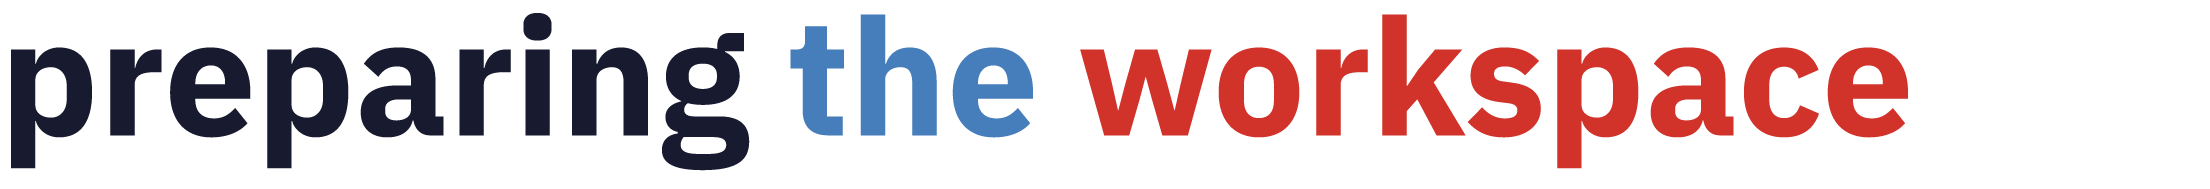

---

### 2.1 Load the data from BigQuery into a pandas DataFrame

---

In [1]:
# import pandas to use DataFrame functionality

import pandas as pd

In [2]:
# authenicate the Google Cloud API

import os

os.environ["GOOGLE_APPLICATION_CREDENTIALS"]=r"C:\Users\david\OneDrive\Documents\Code\political-data-354221-eaf22a72ba45.json"

In [3]:
# load the BigQuery extension

%load_ext google.cloud.bigquery

In [ ]:
# load data from BigQuery and assign it to a DataFrame variable named 'georgia'

In [ ]:
%%bigquery georgia
SELECT * FROM `political-data-354221.datasources.georgia_midterm_elections_2006_through_2018` 

In [5]:
# glimpse

georgia.head()

,state,county,fips_code,election2018_registered_voters,election2018_ballots_cast,election2014_registered_voters,election2014_ballots_cast,election2010_registered_voters,election2010_ballots_cast,election2006_registered_voters,...,census2010_household_income_less_than_10k_pct,census2010_household_income_20_to_40k_pct,census2010_household_income_40_to_60k_pct,census2010_income_60_to_100k_pct,census2010_household_income_100_to_200k_pct,census2010_household_income_200k_or_more_pct,census2010_poverty_pct,census2010_families_with_young_children_pct,census2010_married_households_pct,census2010_households_without_a_car_pct
0,Georgia,Appling,13001,10613,6827,10682,4532,9306,5263,8779,...,0.293,0.241,0.188,0.168,0.106,0.004,0.220,0.251,0.529,0.077
1,Georgia,Atkinson,13003,4252,2527,3791,1713,3640,1492,3539,...,0.302,0.261,0.190,0.184,0.046,0.018,0.280,0.457,0.464,0.077
2,Georgia,Bacon,13005,6010,3836,5051,2271,5003,2537,5015,...,0.325,0.251,0.138,0.163,0.119,0.003,0.157,0.379,0.503,0.062
3,Georgia,Baker,13007,2232,1297,2067,1017,2122,1269,2149,...,0.353,0.259,0.171,0.139,0.059,0.019,0.299,0.453,0.472,0.140
4,Georgia,Baldwin,13009,23399,15690,20626,10774,20299,11528,18319,...,0.294,0.240,0.168,0.188,0.101,0.009,0.219,0.301,0.377,0.097


---

### 2.2 Import the necessary  packages and functions

---

In [8]:
# import data analysis packages

# pandas was already imported in in a previous step
import numpy as np

# import functions from sci-kit learn 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split , KFold 
from sklearn import metrics, model_selection

# import functions from statsmodels
import statsmodels.formula.api as smf

# import data visualization packages
import seaborn as sns
import matplotlib.pyplot as plt

---

### 2.3 Configure display settings to make the notebook easier to read and understand

---

In [11]:
# allow graphs to display in the notebook inline

%matplotlib inline

In [77]:
# set theme for data visualizations

sns.set_theme(
    context='poster', 
    style='whitegrid', 
    palette='Accent', 
    font='Courier New', 
    font_scale=1.5) 

In [13]:
# set Markdown tables to align left within notebook cells

In [12]:
%%html
<style>
table {float:left}
</style>

In [102]:
# do not display warnings

import warnings
warnings.filterwarnings('ignore')

---

---

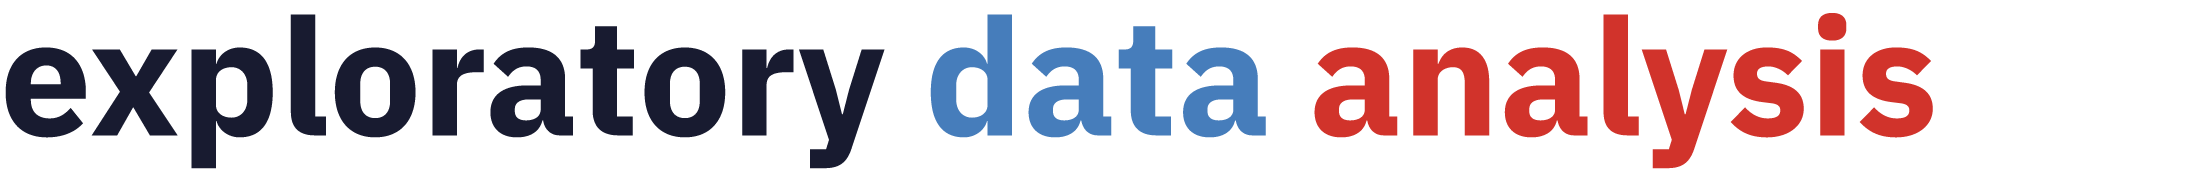

---

### 3.1 Print the first 5 and the last 5 rows of the DataFrame

---

In [23]:
georgia.head()

,state,county,fips_code,election2018_registered_voters,election2018_ballots_cast,election2014_registered_voters,election2014_ballots_cast,election2010_registered_voters,election2010_ballots_cast,election2006_registered_voters,...,census2010_household_income_less_than_10k_pct,census2010_household_income_20_to_40k_pct,census2010_household_income_40_to_60k_pct,census2010_income_60_to_100k_pct,census2010_household_income_100_to_200k_pct,census2010_household_income_200k_or_more_pct,census2010_poverty_pct,census2010_families_with_young_children_pct,census2010_married_households_pct,census2010_households_without_a_car_pct
0,Georgia,Appling,13001,10613,6827,10682,4532,9306,5263,8779,...,0.293,0.241,0.188,0.168,0.106,0.004,0.220,0.251,0.529,0.077
1,Georgia,Atkinson,13003,4252,2527,3791,1713,3640,1492,3539,...,0.302,0.261,0.190,0.184,0.046,0.018,0.280,0.457,0.464,0.077
2,Georgia,Bacon,13005,6010,3836,5051,2271,5003,2537,5015,...,0.325,0.251,0.138,0.163,0.119,0.003,0.157,0.379,0.503,0.062
3,Georgia,Baker,13007,2232,1297,2067,1017,2122,1269,2149,...,0.353,0.259,0.171,0.139,0.059,0.019,0.299,0.453,0.472,0.140
4,Georgia,Baldwin,13009,23399,15690,20626,10774,20299,11528,18319,...,0.294,0.240,0.168,0.188,0.101,0.009,0.219,0.301,0.377,0.097


In [24]:
georgia.tail()

,state,county,fips_code,election2018_registered_voters,election2018_ballots_cast,election2014_registered_voters,election2014_ballots_cast,election2010_registered_voters,election2010_ballots_cast,election2006_registered_voters,...,census2010_household_income_less_than_10k_pct,census2010_household_income_20_to_40k_pct,census2010_household_income_40_to_60k_pct,census2010_income_60_to_100k_pct,census2010_household_income_100_to_200k_pct,census2010_household_income_200k_or_more_pct,census2010_poverty_pct,census2010_families_with_young_children_pct,census2010_married_households_pct,census2010_households_without_a_car_pct
154,Georgia,Whitfield,13313,46058,27432,37642,16118,37619,16471,36285,...,0.223,0.249,0.204,0.188,0.114,0.022,0.189,0.378,0.539,0.049
155,Georgia,Wilcox,13315,4237,2824,3899,1935,4105,2147,3627,...,0.377,0.252,0.153,0.160,0.052,0.006,0.202,0.303,0.459,0.127
156,Georgia,Wilkes,13317,6345,4394,5874,3195,6010,3905,5901,...,0.385,0.233,0.151,0.174,0.048,0.009,0.251,0.328,0.374,0.120
157,Georgia,Wilkinson,13319,6016,4276,5376,3267,5582,3490,5495,...,0.267,0.267,0.161,0.218,0.074,0.013,0.222,0.239,0.479,0.073
158,Georgia,Worth,13321,12645,7867,10826,5300,11106,6069,10037,...,0.263,0.245,0.188,0.217,0.079,0.009,0.205,0.265,0.493,0.071


---

### 3.2 Find the total number of null values in the DataFrame

---

In [28]:
# increase the max number of rows that can be displayed to accomodte the results
pd.options.display.max_rows = 88

# find the sum of all null values
georgia.isna().sum()

state                                                         0
county                                                        0
fips_code                                                     0
election2018_registered_voters                                0
election2018_ballots_cast                                     0
election2014_registered_voters                                0
election2014_ballots_cast                                     0
election2010_registered_voters                                0
election2010_ballots_cast                                     0
election2006_registered_voters                                0
election2006_ballots_cast                                     0
census2018_white_pct                                          0
census2018_black_pct                                          0
census2018_hispanic_pct                                       0
census2018_asian_pct                                          0
census2018_amerindian_pct               

---

### 3.3 Find the index of the DataFrame

---

In [32]:
georgia.index

RangeIndex(start=0, stop=159, step=1)

---

### 3.4 Find the data type for each column

---

In [33]:
georgia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 88 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   state                                                       159 non-null    object 
 1   county                                                      159 non-null    object 
 2   fips_code                                                   159 non-null    object 
 3   election2018_registered_voters                              159 non-null    Int64  
 4   election2018_ballots_cast                                   159 non-null    Int64  
 5   election2014_registered_voters                              159 non-null    Int64  
 6   election2014_ballots_cast                                   159 non-null    Int64  
 7   election2010_registered_voters                              159 non-null    Int64  
 8   

---

### 3.5 Find the shape of the DataFrame

---

In [35]:
georgia.shape

(159, 88)

---

### 3.6 Calculate summary statistics for the DataFrame

---

In [36]:
georgia.describe()

,election2018_registered_voters,election2018_ballots_cast,election2014_registered_voters,election2014_ballots_cast,election2010_registered_voters,election2010_ballots_cast,election2006_registered_voters,election2006_ballots_cast,census2018_white_pct,census2018_black_pct,...,census2010_household_income_less_than_10k_pct,census2010_household_income_20_to_40k_pct,census2010_household_income_40_to_60k_pct,census2010_income_60_to_100k_pct,census2010_household_income_100_to_200k_pct,census2010_household_income_200k_or_more_pct,census2010_poverty_pct,census2010_families_with_young_children_pct,census2010_married_households_pct,census2010_households_without_a_car_pct
count,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,...,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,40431.327044,24841.238994,32648.943396,16331.666667,31650.025157,16493.880503,27728.553459,13427.094340,0.622899,0.282145,...,0.263648,0.243943,0.179031,0.195145,0.101377,0.016893,0.189126,0.300409,0.500503,0.074189
std,91009.490330,55916.922980,72258.250924,36669.714767,68335.150993,36010.279065,59503.861817,28975.683482,0.173052,0.176715,...,0.081387,0.041610,0.027644,0.047033,0.052842,0.016208,0.060539,0.062317,0.081452,0.035953
min,1211.000000,938.000000,1200.000000,591.000000,1330.000000,607.000000,1276.000000,551.000000,0.107000,0.003000,...,0.080000,0.108000,0.096000,0.064000,0.017000,0.000000,0.047000,0.125000,0.237000,0.017000
25%,6208.500000,3995.000000,5563.000000,2898.000000,5735.500000,3255.000000,5429.500000,2689.500000,0.530500,0.147500,...,0.214500,0.221500,0.161500,0.166000,0.068000,0.007000,0.149500,0.257000,0.448000,0.045000
50%,13546.000000,8758.000000,11427.000000,6094.000000,11491.000000,6264.000000,10814.000000,5236.000000,0.619000,0.280000,...,0.268000,0.246000,0.178000,0.188000,0.088000,0.013000,0.190000,0.304000,0.499000,0.066000
75%,30568.500000,18428.000000,25180.500000,11938.500000,24732.000000,12621.000000,22071.500000,10397.500000,0.734000,0.399500,...,0.323500,0.267000,0.193500,0.224000,0.114500,0.021000,0.229500,0.338000,0.557500,0.095500
max,703177.000000,424991.000000,561266.000000,269841.000000,520582.000000,260358.000000,452303.000000,206366.000000,0.951000,0.723000,...,0.460000,0.374000,0.275000,0.332000,0.326000,0.094000,0.342000,0.545000,0.696000,0.184000


---

### 3.7 Find the trends in turnout percentage from 2006 to 2018

---

In [45]:
# calculate 2006 turnout percentage for the state of Georgia

print(georgia['election2006_ballots_cast'].sum() / georgia['election2006_registered_voters'].sum())

0.4842334945246369


In [46]:
# calculate 2010 turnout percentage for the state of Georgia

print(georgia['election2010_ballots_cast'].sum() / georgia['election2010_registered_voters'].sum())

0.52113325095969


In [47]:
# calculate 2014 turnout percentage for the state of Georgia

print(georgia['election2014_ballots_cast'].sum() / georgia['election2014_registered_voters'].sum())

0.5002203737029447


In [48]:
# calculate 2018 turnout percentage for the state of Georgia

print(georgia['election2018_ballots_cast'].sum() / georgia['election2018_registered_voters'].sum())

0.6144057296625803


---

### 3.8 Find the Georgia counties with the highest turnout percentages in 2006

---

In [56]:
georgia['2006_turnout_pct'] = georgia['election2006_ballots_cast'] / georgia['election2006_registered_voters']

In [60]:
georgia[['county', '2006_turnout_pct']].nlargest(5, '2006_turnout_pct')

,county,2006_turnout_pct
107,Oconee,0.60321
118,Rabun,0.587516
97,McIntosh,0.586832
103,Morgan,0.582062
72,Hart,0.578646


---

### 3.9 Find the Georgia counties with the highest turnout percentages in 2010

---

In [58]:
georgia['2010_turnout_pct'] = georgia['election2010_ballots_cast'] / georgia['election2010_registered_voters']

In [59]:
georgia[['county', '2010_turnout_pct']].nlargest(5, '2010_turnout_pct')

,county,2010_turnout_pct
151,Webster,0.686556
156,Wilkes,0.64975
29,Clay,0.645737
89,Lincoln,0.633763
157,Wilkinson,0.625224


---

### 3.10 Find the Georgia counties with the highest turnout percentages in 2014

---

In [62]:
georgia['2014_turnout_pct'] = georgia['election2014_ballots_cast'] / georgia['election2014_registered_voters']

In [64]:
georgia[['county', '2018_turnout_pct']].nlargest(5, '2018_turnout_pct')

,county,2018_turnout_pct
130,Taliaferro,0.774566
107,Oconee,0.755175
65,Greene,0.747041
151,Webster,0.738111
122,Schley,0.732325


---

### 3.11 Find the Georgia counties with the highest turnout percentages in 2018

---

In [65]:
georgia['2018_turnout_pct'] = georgia['election2018_ballots_cast'] / georgia['election2018_registered_voters']

In [66]:
georgia[['county', '2018_turnout_pct']].nlargest(5, '2018_turnout_pct')

,county,2018_turnout_pct
130,Taliaferro,0.774566
107,Oconee,0.755175
65,Greene,0.747041
151,Webster,0.738111
122,Schley,0.732325


---

### 3.12 Explore possible correlations between 2018 census data and the 2018 turnout percentages

---

In [69]:
# create a subset of selected census data columns

census_cols = ['2018_turnout_pct','census2018_white_pct', 'census2018_highest_edudation_level_bachelors_degree_pct', 
               'census2018_poverty_pct', 'census2018_families_with_young_children_pct', 
               'census2018_married_households_pct', 'census2018_households_without_a_car_pct']

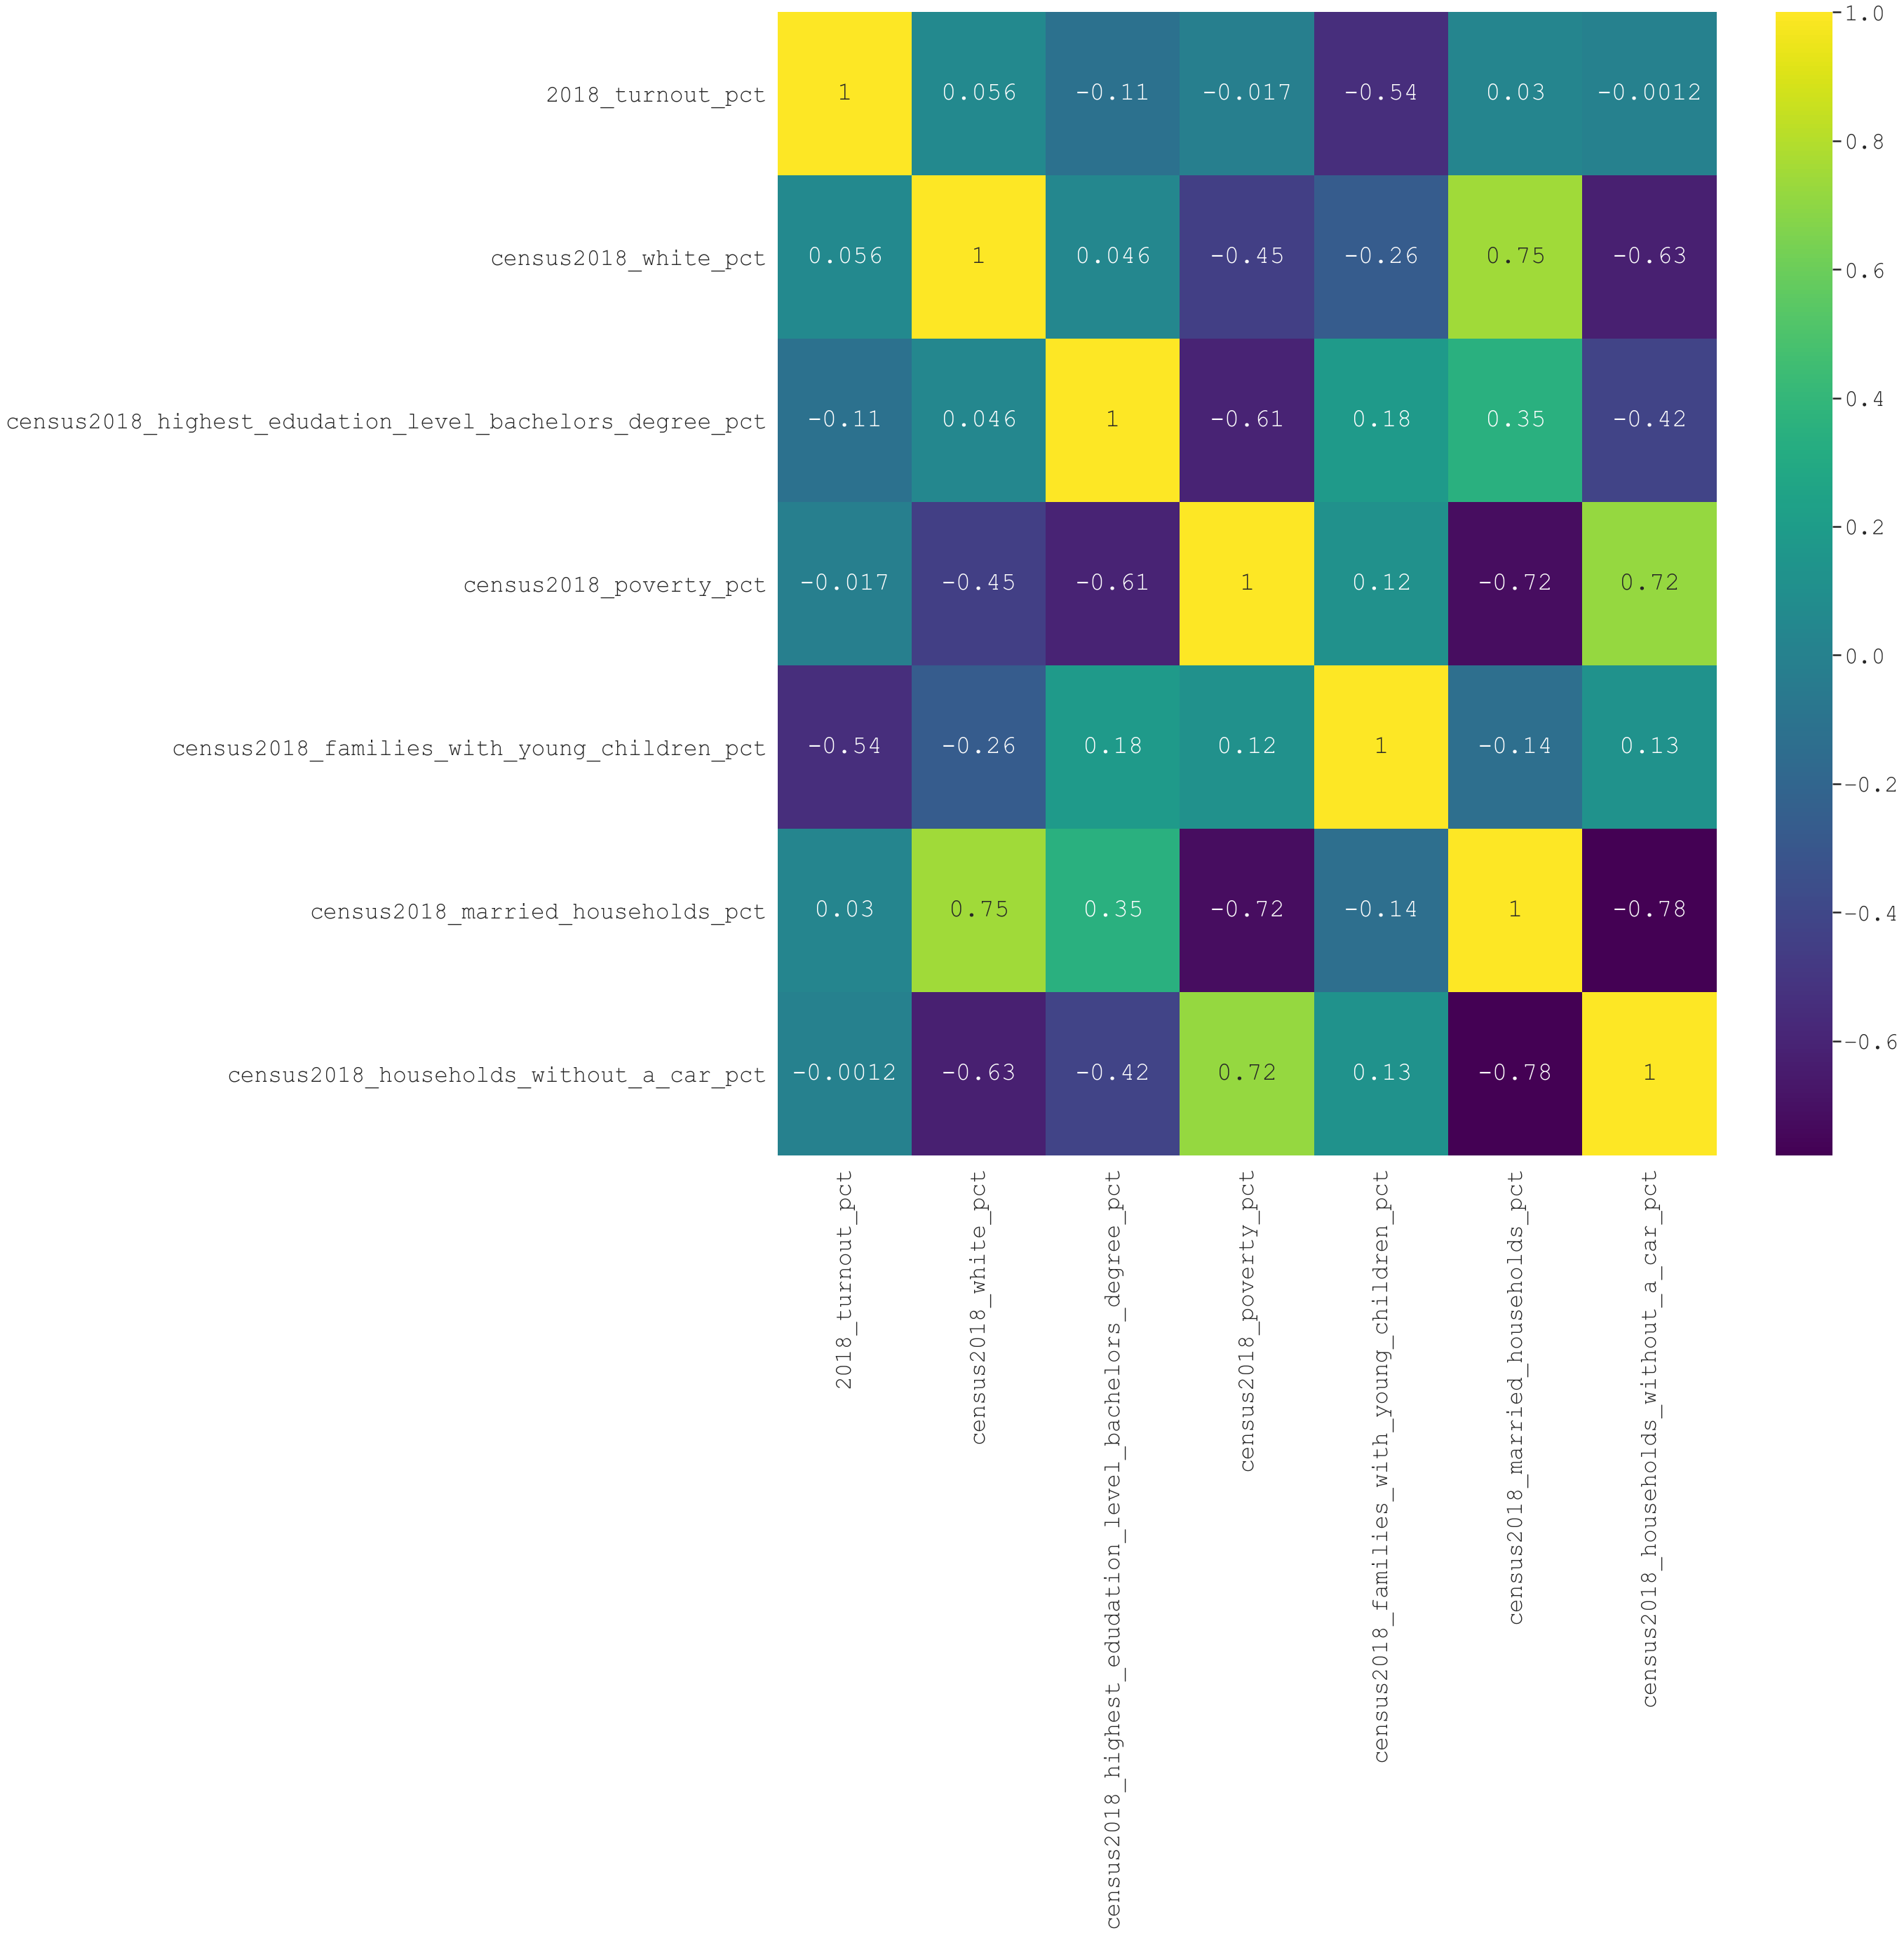

In [81]:
# plot correlation matrix

census_corr = georgia[census_cols].corr()

plt.figure(figsize=(30,30))
sns.heatmap(census_corr, annot=True, cmap='viridis') ;

---

---

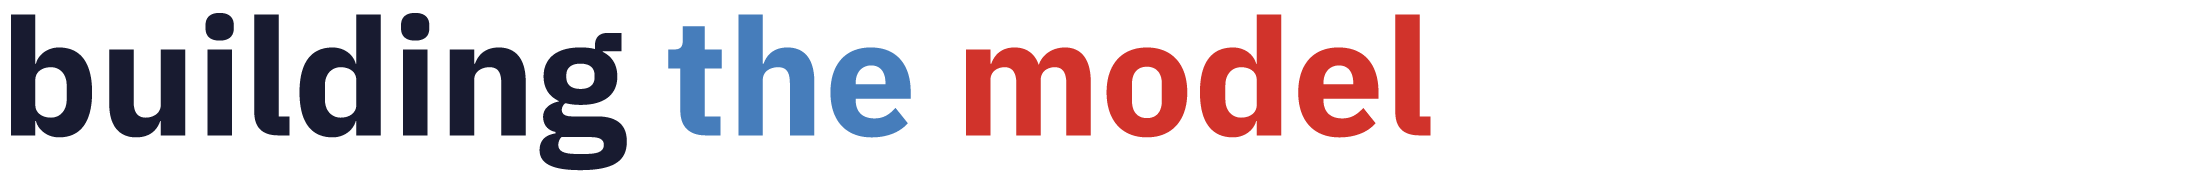

---

### 4.1 Add weights to 2014, 2010 and 2006 election results to account for recency and up-ballot effects

---

In [195]:
# 2014 had two relatively close statewide races (governor and senate) that were likely drivers of turnout

georgia['weighted_ballots_cast_2014'] = georgia['election2014_ballots_cast'] * .85 

In [196]:
# 2010 had two statewide races (governor and senate) that were likely drivers of turnout
# the final margin at the top of the ticket was more than 10 points which likely mitigated turnout

georgia['weighted_ballots_cast_2010'] = georgia['election2010_ballots_cast'] * .35 

In [197]:
# 2006 was the least recent election in our data set and feautred only one statewide race as opposed to two

georgia['weighted_ballots_cast_2006'] = georgia['election2006_ballots_cast'] * .15 

---

### 4.2 Fit the model

---

In [198]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

In [199]:
# select features (drop non-numeric columns and the target)

X = georgia.drop(['state', 'county', 'fips_code', 'election2018_ballots_cast',
                 '2018_turnout_pct','2014_turnout_pct', '2010_turnout_pct', '2006_turnout_pct'], axis=1)

In [200]:
# assign 2018 ballots cast to to the target 

y = georgia['election2018_ballots_cast']

In [201]:
lr.fit(X,y)

LinearRegression()

In [202]:
y_pred = lr.predict(X)

In [203]:
print(np.sqrt(metrics.mean_squared_error(y, y_pred)))

753.1601942040684


---

### 4.3 Improve the model by selecting the best Train-Test Split

---

In [204]:
from sklearn.model_selection import train_test_split

#### 4.3.1 90-10 Train-Test Split

In [205]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

In [206]:
# train the model on the training set

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [207]:
# test the model on the testing set and print the accuracy metrics

y_pred = lr.predict(X_test)

print(np.sqrt(metrics.mean_squared_error(y_train, lr.predict(X_train))))
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

530.9675843315755
2544.543464138687


#### 4.3.2 85-15 Train-Test Split

In [208]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [209]:
# train the model on the training set

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [210]:
# test the model on the testing set and print the accuracy metrics

y_pred = lr.predict(X_test)

print(np.sqrt(metrics.mean_squared_error(y_train, lr.predict(X_train))))
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

523.4711244601388
2122.67269056493


#### 4.3.3 80-20 Train-Test Split

In [211]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [212]:
# train the model on the training set

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [213]:
# test the model on the testing set and print the accuracy metrics

y_pred = lr.predict(X_test)

print(np.sqrt(metrics.mean_squared_error(y_train, lr.predict(X_train))))
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

490.3786912192622
2139.5893799345035


#### 4.3.4 75-25 Train-Test Split

In [214]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [215]:
# train the model on the training set

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [216]:
# test the model on the testing set and print the accuracy metrics

y_pred = lr.predict(X_test)

print(np.sqrt(metrics.mean_squared_error(y_train, lr.predict(X_train))))
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

426.28234483294557
2418.0081426726265


#### 4.3.5 70-30 Train-Test Split

In [217]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

In [218]:
# train the model on the training set

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [219]:
# test the model on the testing set and print the accuracy metrics

y_pred = lr.predict(X_test)

print(np.sqrt(metrics.mean_squared_error(y_train, lr.predict(X_train))))
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

530.9675843315755
2544.543464138687


---

***Conclusion: The 85-15 split produced the best result***

---

---

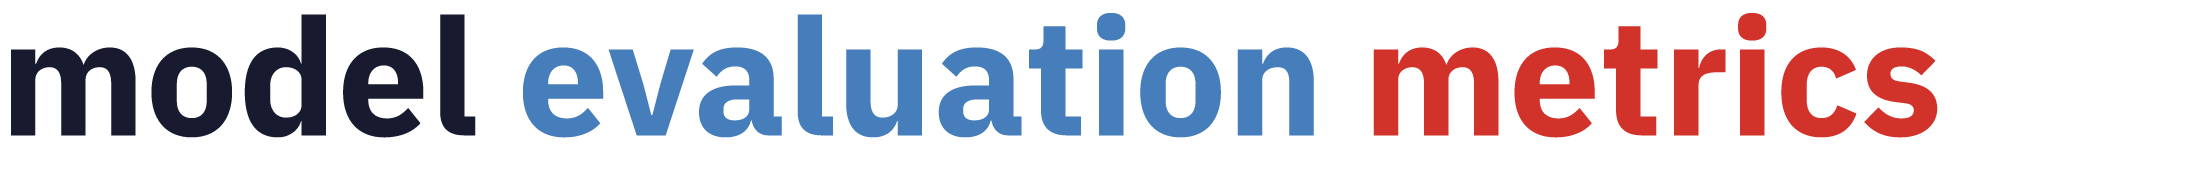

---

### 5.1 Find the RMSE of the traditional prediction method

---

In [295]:
# the traditional method projects turnout to be the average of the last 3 similar elections

georgia['2018_traditional_method_proj_ballots_cast'] = (georgia['election2014_ballots_cast'] + 
                                                        georgia['election2010_ballots_cast'] +
                                                        georgia['election2006_ballots_cast'])/3

In [296]:
# y_true is the actual number of ballots cast

y = georgia['election2018_ballots_cast']

In [301]:
y

0       6827
1       2527
2       3836
3       1297
4      15690
       ...  
154    27432
155     2824
156     4394
157     4276
158     7867
Name: election2018_ballots_cast, Length: 159, dtype: Int64

In [297]:
y_pred_traditional = georgia['2018_traditional_method_proj_ballots_cast'] 

In [298]:
# print the RMSE

print(np.sqrt(metrics.mean_squared_error(y, y_pred_traditional)))

24079.670767078056


---

### 5.2 Calculate the percent difference between the traditional prediction method and our machine learning model

---

In [288]:
traditional_rmse = np.sqrt(metrics.mean_squared_error(y, y_pred_traditional))

In [289]:
# use the best performing train-test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

ml_rmse = np.sqrt(metrics.mean_squared_error(y_test, lr.predict(X_test)))

In [316]:
# find the difference between the traditional method RMSE and the machine learning method RMSE

(traditional_rmse - ml_rmse) / traditional_rmse

0.9118479355013829

---

### 5.3 Compare traditional predictions side-by-side with actuals

---

In [312]:
y_pred

array([  4905.29261888,   2224.30789509,  10663.07433642,  58775.5407941 ,
        11896.48488796,   1760.84035784,   9632.10993511,   7224.55066169,
         8512.28485008,   3438.76407681,  18085.47890328,  11758.85953959,
        22969.58307323,  10140.41697152, 110263.59514101,  99454.27070793,
         9097.31708656,  14554.97383537,   7699.664369  ,   8623.05450558,
          987.84403796,    242.2096029 ,   6516.50251577,   7746.46502418])

In [314]:
georgia['2018_ml_predictions'] = lr.predict(X)

In [315]:
pd.options.display.max_rows = 159

georgia[['county','election2014_ballots_cast', 'election2010_ballots_cast', 
         'election2006_ballots_cast', '2018_traditional_method_proj_ballots_cast', 
         'election2018_ballots_cast', '2018_ml_predictions']]

,county,election2014_ballots_cast,election2010_ballots_cast,election2006_ballots_cast,2018_traditional_method_proj_ballots_cast,election2018_ballots_cast,2018_ml_predictions
0,Appling,4532,5263,4170,4655.0,6827,6989.902972
1,Atkinson,1713,1492,1500,1568.333333,2527,2842.336244
2,Bacon,2271,2537,2370,2392.666667,3836,3963.360917
3,Baker,1017,1269,1014,1100.0,1297,1983.338291
4,Baldwin,10774,11528,10123,10808.333333,15690,15115.565537
5,Banks,4385,4520,3951,4285.333333,6867,7314.286039
6,Barrow,16368,16318,11660,14782.0,27459,27395.719496
7,Bartow,23147,23760,19263,22056.666667,37441,36618.850225
8,Ben Hill,3565,4037,3331,3644.333333,5565,5498.198361
9,Berrien,3795,4105,3665,3855.0,6265,7746.465024


---

---

---